In [ ]:
# %%bash
# ────────────────────────────────────────────────────────────
# Minimal package bootstrap (only what we really use)
# ────────────────────────────────────────────────────────────
%pip install -qU "trino[sqlalchemy]==0.332.0" polars matplotlib


Note: you may need to restart the kernel to use updated packages.


In [ ]:

# %%
# ────────────────────────────────────────────────────────────
# Imports
# ────────────────────────────────────────────────────────────
import os
import re
import json
import datetime as dt
from pathlib import Path
from typing import Tuple, Optional

import pandas as pd
import numpy as np        # Integrated: for datetime type checking
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sqlalchemy.engine import create_engine


In [ ]:

# ────────────────────────────────────────────────────────────
# Helper: robust host:port parser with TCP‑range clamp
# ────────────────────────────────────────────────────────────
def _parse_host_port(host: Optional[str], port: Optional[str],
                     default_port: int = 8080) -> Tuple[str, int]:
    host = (host or "").strip()
    port = (port or "").strip()
    host = re.sub(r"^(?:https?|tcp)://", "", host, flags=re.I)  # strip scheme
    if ":" in host and not port:
        host, port = host.split(":", 1)
    try:
        port_int = int(re.sub(r"\D", "", port))
    except ValueError:
        port_int = default_port
    if not (1 <= port_int <= 65_535):
        port_int = default_port
    return host or "localhost", port_int


In [ ]:
# ────────────────────────────────────────────────────────────
# Environment variables (override in shell if needed)
# ────────────────────────────────────────────────────────────
TRINO_HOST, TRINO_PORT = _parse_host_port(
    os.getenv("TRINO_HOST"),
    os.getenv("TRINO_PORT"),
)
TRINO_USER    = os.getenv("TRINO_USER",    "jupyter")
TRINO_CATALOG = os.getenv("TRINO_CATALOG", "iceberg")
TRINO_SCHEMA  = os.getenv("TRINO_SCHEMA")          # optional

print(f"🔌 Trino → {TRINO_HOST}:{TRINO_PORT}  catalog={TRINO_CATALOG!r} "
      f"(requested schema={TRINO_SCHEMA or '❓ auto‑detect'})")


🔌 Trino → trino:8080  catalog='iceberg' (requested schema=❓ auto‑detect)


In [ ]:


# %%
# ────────────────────────────────────────────────────────────
# JSON + plotting helpers (extended with auto‑date formatting)
# ────────────────────────────────────────────────────────────
def _json_default(value):
    if isinstance(value, (dt.datetime, dt.date)):
        return value.isoformat()
    return repr(value)

def save_dict(d: dict, path: Path):
    path.write_text(json.dumps(d, default=_json_default))

def load_dict(path: Path) -> dict:
    return json.loads(path.read_text())

def df_from_data_d(data_d: dict) -> pl.DataFrame:
    """Recreate Polars DataFrame; parse 'date' back to datetime."""
    return pl.DataFrame(data_d, schema_overrides={"date": pl.Datetime})

def _maybe_format_date_axis(ax, x_values):
    """
    If *x_values* looks like datetime, install an AutoDateLocator and a DateFormatter
    with 'DD-MM-YYYY' format on tick labels to avoid clutter.
    """
    # Accept pandas Series, numpy array, or Polars Series
    if hasattr(x_values, "to_numpy"):
        x_array = x_values.to_numpy()
    else:
        x_array = x_values

    # Determine if x_array contains datetime values (check dtype or first element)
    first_elem = None
    if hasattr(x_array, "__len__") and len(x_array) > 0:
        try:
            first_elem = x_array[0]
        except Exception:
            try:
                first_elem = next(iter(x_array))
            except StopIteration:
                first_elem = None

    if pd.api.types.is_datetime64_any_dtype(x_array) or isinstance(first_elem, (pd.Timestamp, np.datetime64)):
        # Use AutoDateLocator for smart date tick spacing
        locator   = mdates.AutoDateLocator()
        # Use DateFormatter for fixed "DD-MM-YYYY" format on tick labels
        formatter = mdates.DateFormatter('%d-%m-%Y')
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        # Rotate and align date labels for readability (auto-format)
        ax.figure.autofmt_xdate()

def plot_from_d(data, plot_d: dict, ax, **kwargs):
    """
    Generic plotting helper (bar, line, scatter, diff) that automatically
    prettifies a datetime x‑axis.
    """
    chart = plot_d["chart_type"]
    x_key = plot_d["x_data"]

    if chart == "bar":
        # If multiple series (y_data is None), this will not be used; handled manually instead.
        ax.bar(x_key, plot_d.get("y_data", []), data=data, **kwargs)
    elif chart == "line":
        ax.plot(x_key, plot_d["y_data"], data=data, **kwargs)
    elif chart == "scatter":
        ax.scatter(x_key, plot_d["y_data"], data=data, **kwargs)
    elif chart == "diff":
        plot_data = pl.DataFrame(data) if not isinstance(data, pl.DataFrame) else data
        plot_data = plot_data.with_columns(
            x   = pl.col(x_key),
            pos = pl.col(plot_d["pos_y_data"]),
            neg = -pl.col(plot_d["neg_y_data"])
        ).with_columns(diff = pl.col("pos") + pl.col("neg"))
        ax.bar("x", "pos", data=plot_data, fc="seagreen", **kwargs)
        ax.bar("x", "neg", data=plot_data, fc="indianred", **kwargs)
        ax.plot("x", "diff", data=plot_data, c="k", ls="--")
        ax.axhline(0, color="yellow")  # highlight zero baseline
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels([int(abs(t)) for t in ax.get_yticks()])

    # Labels, scales
    ax.set_xlabel(plot_d.get("xlabel"))
    ax.set_ylabel(plot_d.get("ylabel"))
    ax.set_title(plot_d.get("title"), fontsize=14)
    ax.set_xscale(plot_d.get("xscale", "linear"))
    ax.set_yscale(plot_d.get("yscale", "linear"))

    # Auto‑date formatting (apply date formatter if needed)
    _maybe_format_date_axis(ax, data[x_key])

    return ax


In [ ]:

# %%
# ────────────────────────────────────────────────────────────
# Locate schema containing collected_news (original logic)
# ────────────────────────────────────────────────────────────
TARGET_TABLE = "collected_news"
engine_cat = create_engine(
    f"trino://{TRINO_USER}@{TRINO_HOST}:{TRINO_PORT}/{TRINO_CATALOG}"
)
def find_schema_with_table(engine, catalog: str,
                           table: str,
                           preferred: Optional[str] = None) -> str:
    with engine.connect() as conn:
        schemas = pd.read_sql(f"SHOW SCHEMAS FROM {catalog}", conn)["Schema"].tolist()
        if preferred:
            if preferred not in schemas:
                raise ValueError(f"Schema '{preferred}' not found in catalog '{catalog}'. "
                                 f"Available: {schemas}")
            tables = pd.read_sql(f"SHOW TABLES FROM {catalog}.{preferred}", conn)["Table"].tolist()
            if table not in tables:
                raise ValueError(f"Table '{table}' not found in schema '{preferred}'.")
            return preferred
        for sch in schemas:
            tables = pd.read_sql(f"SHOW TABLES FROM {catalog}.{sch}", conn)["Table"].tolist()
            if table in tables:
                return sch
    raise ValueError(f"Table '{table}' not found in any schema of catalog '{catalog}'.")

ACTIVE_SCHEMA = find_schema_with_table(engine_cat, TRINO_CATALOG,
                                       TARGET_TABLE, TRINO_SCHEMA)
print(f"✅ Using schema → {ACTIVE_SCHEMA!r}")


✅ Using schema → 'news'


In [ ]:

# %%
# ────────────────────────────────────────────────────────────
# Retrieve the data (news articles and reliability scores)
# ────────────────────────────────────────────────────────────
COLUMNS_NEEDED = [
    "url", "publish_date", "created_at", "language",
    "topic", "keyword", "domain", "sourcecountry",
]
TABLE_FQN   = f"{TRINO_CATALOG}.{ACTIVE_SCHEMA}.{TARGET_TABLE}"
DATE_FILTER = ""  # e.g.,  WHERE publish_date >= DATE '2025-01-01'
SQL = f"""
SELECT {', '.join(COLUMNS_NEEDED)}
FROM   {TABLE_FQN}
{DATE_FILTER}
"""
with engine_cat.connect() as conn:
    df_raw = pd.read_sql(SQL, conn)
print(f"✅ Retrieved {len(df_raw):,} rows")

# Connect to the database catalog 'db' to get domain reliability data
engine_db = create_engine(f"trino://{TRINO_USER}@{TRINO_HOST}:{TRINO_PORT}/db")
with engine_db.connect() as conn:
    df_lasser = pd.read_sql("SELECT domain, pc1 AS reliability FROM news.lasser_dq_scores", conn)
# Optionally convert to Polars and display shape for verification
lin_lasser_data = pl.from_pandas(df_lasser)
print(lin_lasser_data)  # Displays shape and example rows of domain reliability data


✅ Retrieved 202,422 rows
shape: (11_520, 2)
┌──────────────────────┬─────────────┐
│ domain               ┆ reliability │
│ ---                  ┆ ---         │
│ str                  ┆ f64         │
╞══════════════════════╪═════════════╡
│ reuters.com          ┆ 1.0         │
│ apnews.com           ┆ 0.998049    │
│ charitynavigator.org ┆ 0.985752    │
│ rollcall.com         ┆ 0.982851    │
│ smithsonianmag.com   ┆ 0.971184    │
│ …                    ┆ …           │
│ stormfront.org       ┆ 0.044752    │
│ pandemic.news        ┆ 0.043817    │
│ davidicke.com        ┆ 0.041614    │
│ worldtruth.tv        ┆ 0.017644    │
│ naturalnews.com      ┆ 0.0         │
└──────────────────────┴─────────────┘


In [ ]:

# %%
# ────────────────────────────────────────────────────────────
# Timestamp clean‑up + deduplication
# ────────────────────────────────────────────────────────────
for col in ("publish_date", "created_at"):
    df_raw[col] = (
        pd.to_datetime(df_raw[col], errors="coerce", utc=True)
          .dt.tz_localize(None)
    )
df_dedup = df_raw.drop_duplicates(subset="url").reset_index(drop=True)
print(f"📉 After deduplication: {len(df_dedup):,} unique URLs "
      f"({len(df_raw) - len(df_dedup):,} duplicates removed)")


📉 After deduplication: 149,833 unique URLs (52,589 duplicates removed)


In [ ]:

# %%
# ────────────────────────────────────────────────────────────
# Define reliability thresholds and filter time window
# ────────────────────────────────────────────────────────────
low_threshold = 0.4
high_threshold = 0.6

# Create a dictionary for domain → reliability mapping
domain_reliability_map = df_lasser.set_index("domain")["reliability"].to_dict()
# Add reliability column to df_dedup using the dictionary (NaN if domain not found)
df_dedup["reliability"] = df_dedup["domain"].map(domain_reliability_map)
# Classify each article as reliable, unreliable, or mid (in-between) based on thresholds
df_dedup["reliability_category"] = "mid"
df_dedup.loc[df_dedup["reliability"] > high_threshold, "reliability_category"] = "reliable"
df_dedup.loc[df_dedup["reliability"] < low_threshold, "reliability_category"] = "unreliable"

WINDOW_START = pd.to_datetime("2025-03-07")
WINDOW_END   = pd.to_datetime("2025-06-07")

mask = df_dedup["publish_date"].between(WINDOW_START, WINDOW_END)
df_window = df_dedup.loc[mask].copy()
df_window["date"] = df_window["publish_date"].dt.floor("D")


In [ ]:
# ────────────────────────────────────────────────────────────
# DAILY news counts (diverging: reliable vs unreliable)
# ────────────────────────────────────────────────────────────
# Filter to only reliable or unreliable (exclude 'mid')
daily_rel = df_window[df_window["reliability_category"] == "reliable"] \
    .groupby("date").size().reset_index(name="reliable_count")
daily_unrel = df_window[df_window["reliability_category"] == "unreliable"] \
    .groupby("date").size().reset_index(name="unreliable_count")
daily_diverging_df = pd.merge(daily_rel, daily_unrel, on="date", how="outer").fillna(0).sort_values("date")
daily_diverging_df["reliable_count"] = daily_diverging_df["reliable_count"].astype(int)
daily_diverging_df["unreliable_count"] = daily_diverging_df["unreliable_count"].astype(int)
# Convert to Polars for JSON export
daily_diverging_pl = pl.from_pandas(daily_diverging_df)


In [ ]:

# 1️⃣ SAVE data + metadata → daily_news_counts_diverging.json
plot_path = Path("daily_news_counts_diverging.json")
plot_d = {
    "data"      : daily_diverging_pl.to_dict(as_series=False),
    "title"     : "Daily number of news items (Reliable vs Unreliable)",
    "xlabel"    : "Date",
    "ylabel"    : "Number of news items",
    "x_data"    : "date",
    "y_data"    : None,             # multiple series (Reliable and Unreliable)
    "chart_type": "bar",
    "platform"  : "News",
}
save_dict(plot_d, plot_path)
print(f"💾 JSON saved → {plot_path.resolve()}")


💾 JSON saved → /home/kadkhoda/daily_news_counts_diverging.json


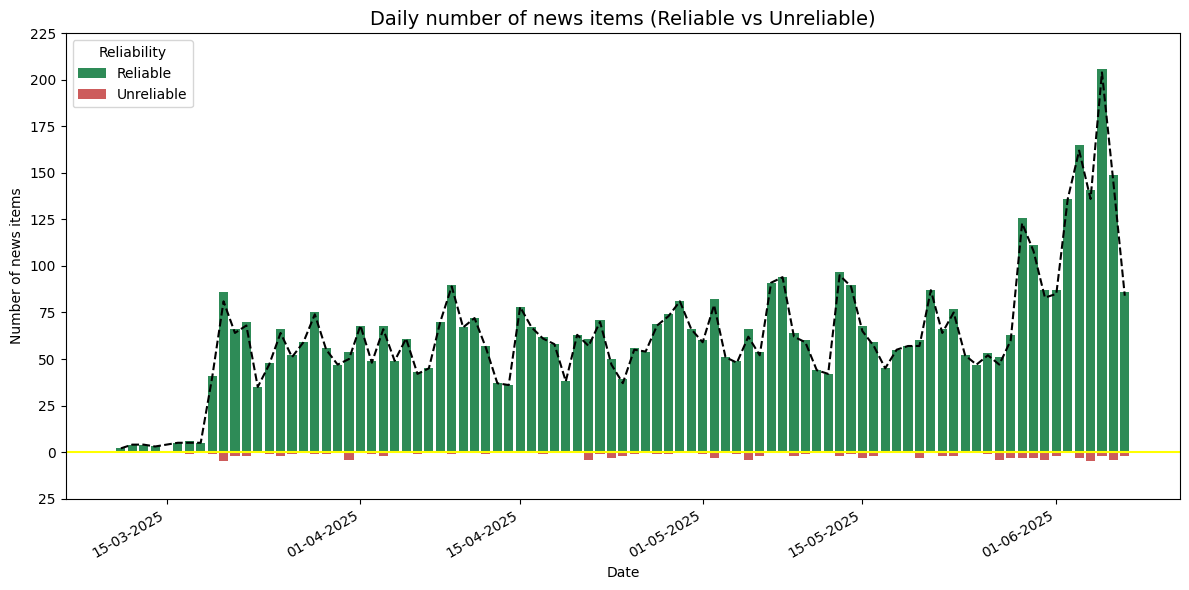

In [ ]:


# %%
# 2️⃣ LOAD the JSON and recreate the diverging bar plot (Reliable vs Unreliable)
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas()
df_loaded_pd.sort_values("date", inplace=True)
# Prepare DataFrame for plotting (treat Reliable and Unreliable as categories)
df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
df_plot["Reliable_reliable"] = df_loaded_pd["reliable_count"].astype(int)
df_plot["Unreliable_unreliable"] = df_loaded_pd["unreliable_count"].astype(int)
categories = ["Reliable", "Unreliable"]
# Ensure both reliable and unreliable columns exist for each category
for cat in categories:
    rel_col = f"{cat}_reliable"
    unrel_col = f"{cat}_unreliable"
    if rel_col not in df_plot.columns:
        df_plot[rel_col] = 0
    if unrel_col not in df_plot.columns:
        df_plot[unrel_col] = 0
# Plot diverging stacked bars for reliability categories
fig, ax = plt.subplots(figsize=(12, 6))
# Set color scheme for reliability categories (green for reliable, red for unreliable)
colors_map = {"Reliable": "seagreen", "Unreliable": "indianred"}
# Plot positive (reliable) portion
bottom_pos = np.zeros(len(df_plot))
for cat in categories:
    rel_col = f"{cat}_reliable"
    ax.bar(df_plot["date"], df_plot[rel_col], bottom=bottom_pos, color=colors_map[cat], label=cat)
    bottom_pos += df_plot[rel_col].to_numpy()
# Plot negative (unreliable) portion
bottom_neg = np.zeros(len(df_plot))
for cat in categories:
    unrel_col = f"{cat}_unreliable"
    ax.bar(df_plot["date"], -df_plot[unrel_col].to_numpy(), bottom=-bottom_neg, color=colors_map[cat])
    bottom_neg += df_plot[unrel_col].to_numpy()
# Plot difference line (Reliable – Unreliable)
diff_series = bottom_pos - bottom_neg
ax.plot(df_plot["date"], diff_series, c="k", ls="--")
ax.axhline(0, color="yellow")  # highlight zero baseline
# Customize axes and legend
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"), fontsize=14)
_maybe_format_date_axis(ax, df_plot["date"])
# Use absolute values for y-axis tick labels
ticks = ax.get_yticks()
ax.set_yticks(ticks, [int(abs(t)) for t in ticks])
ax.legend(title="Reliability")
plt.tight_layout()
plt.show()


In [ ]:

# %%
# ────────────────────────────────────────────────────────────
# LANGUAGE news counts over time (diverging by reliability)
# ────────────────────────────────────────────────────────────
# Group by date, language, and reliability category; count items
lang_counts_df = (
    df_window[df_window["reliability_category"] != "mid"]
    .groupby(["date", "language", "reliability_category"])
    .size()
    .reset_index(name="count")
)
# Pivot to separate reliable and unreliable counts by language
pivot_lang_rel = lang_counts_df[lang_counts_df["reliability_category"] == "reliable"] \
    .pivot(index="date", columns="language", values="count").fillna(0)
pivot_lang_unrel = lang_counts_df[lang_counts_df["reliability_category"] == "unreliable"] \
    .pivot(index="date", columns="language", values="count").fillna(0)
pivot_lang_rel.sort_index(inplace=True)
pivot_lang_unrel.sort_index(inplace=True)
# Convert to integers
pivot_lang_rel = pivot_lang_rel.astype(int)
pivot_lang_unrel = pivot_lang_unrel.astype(int)
# Reset index and rename columns to indicate reliability
pivot_lang_rel_reset = pivot_lang_rel.reset_index()
pivot_lang_unrel_reset = pivot_lang_unrel.reset_index()
if pivot_lang_rel_reset.columns[0] != "date":
    pivot_lang_rel_reset = pivot_lang_rel_reset.rename(columns={"index": "date"})
if pivot_lang_unrel_reset.columns[0] != "date":
    pivot_lang_unrel_reset = pivot_lang_unrel_reset.rename(columns={"index": "date"})
pivot_lang_rel_reset = pivot_lang_rel_reset.rename(columns={col: f"{col}_reliable" for col in pivot_lang_rel_reset.columns if col != "date"})
pivot_lang_unrel_reset = pivot_lang_unrel_reset.rename(columns={col: f"{col}_unreliable" for col in pivot_lang_unrel_reset.columns if col != "date"})
# Merge reliable and unreliable data on date
lang_merged = pd.merge(pivot_lang_rel_reset, pivot_lang_unrel_reset, on="date", how="outer").fillna(0)
lang_merged.sort_values("date", inplace=True)
# Determine number of languages included
lang_cols = [c for c in lang_merged.columns if c != "date"]
languages = set()
for col in lang_cols:
    if col.endswith("_reliable"):
        languages.add(col.replace("_reliable", ""))
    elif col.endswith("_unreliable"):
        languages.add(col.replace("_unreliable", ""))
num_lang = len(languages)
if num_lang > 10:
    print(f"📊 {num_lang} languages found. All languages included in JSON (visualization will default to top 10 with 'Other'; configurable).")
else:
    print(f"📊 {num_lang} languages found. All languages included in JSON.")


📊 8 languages found. All languages included in JSON.


In [ ]:

# Save all language data (including all categories) to JSON
plot_path = Path("language_news_counts_diverging.json")
plot_d = {
    "data"      : pl.from_pandas(lang_merged).to_dict(as_series=False),
    "title"     : "Daily number of news items by language (Reliable vs Unreliable)",
    "xlabel"    : "Date",
    "ylabel"    : "Number of news items",
    "x_data"    : "date",
    "y_data"    : None,             # multiple series (language_reliable and language_unreliable)
    "chart_type": "bar",
    "platform"  : "News",
}
save_dict(plot_d, plot_path)
print(f"💾 JSON saved → {plot_path.resolve()}")


💾 JSON saved → /home/kadkhoda/language_news_counts_diverging.json


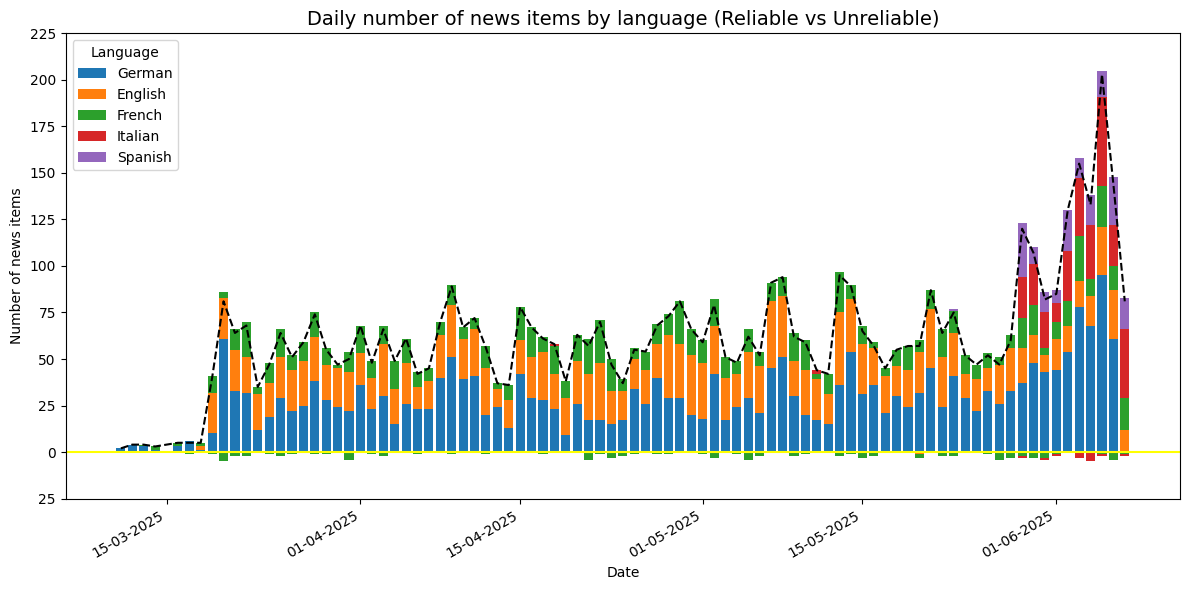

In [ ]:

# %%
# 2️⃣ LOAD the JSON and recreate the diverging bar plot (languages)
TOP_N = 5   # Number of top languages to display
INCLUDE_OTHER = False  # Whether to include an aggregated 'Other' category for remaining languages
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas()
df_loaded_pd.sort_values("date", inplace=True)
# Determine top languages by total reliable+unreliable counts
lang_sums_reliable = df_loaded_pd[[c for c in df_loaded_pd.columns if c.endswith("_reliable")]].sum()
lang_sums_unreliable = df_loaded_pd[[c for c in df_loaded_pd.columns if c.endswith("_unreliable")]].sum()
# Align indices by removing suffix to combine counts per language
lang_sums_reliable.index = [idx.replace("_reliable", "") for idx in lang_sums_reliable.index]
lang_sums_unreliable.index = [idx.replace("_unreliable", "") for idx in lang_sums_unreliable.index]
total_extremes = lang_sums_reliable.add(lang_sums_unreliable, fill_value=0)
if len(total_extremes) > TOP_N:
    top_langs = total_extremes.nlargest(TOP_N).index.tolist()
    other_langs = [lang for lang in total_extremes.index if lang not in top_langs]
else:
    top_langs = total_extremes.index.tolist()
    other_langs = []
# Build dataframe for plotting (only top languages + optional 'Other')
df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
for lang in top_langs:
    rel_col = f"{lang}_reliable"
    unrel_col = f"{lang}_unreliable"
    if rel_col not in df_loaded_pd.columns:
        df_loaded_pd[rel_col] = 0
    if unrel_col not in df_loaded_pd.columns:
        df_loaded_pd[unrel_col] = 0
    df_plot[rel_col] = df_loaded_pd[rel_col]
    df_plot[unrel_col] = df_loaded_pd[unrel_col]
if INCLUDE_OTHER and other_langs:
    # Sum all other languages for reliable and unreliable
    other_rel_cols = [f"{lang}_reliable" for lang in other_langs if f"{lang}_reliable" in df_loaded_pd.columns]
    other_unrel_cols = [f"{lang}_unreliable" for lang in other_langs if f"{lang}_unreliable" in df_loaded_pd.columns]
    df_plot["Other_reliable"] = df_loaded_pd[other_rel_cols].sum(axis=1) if other_rel_cols else 0
    df_plot["Other_unreliable"] = df_loaded_pd[other_unrel_cols].sum(axis=1) if other_unrel_cols else 0
    categories = top_langs + ["Other"]
else:
    categories = top_langs
# Plot diverging stacked bars for languages
fig, ax = plt.subplots(figsize=(12, 6))
# Prepare consistent color cycle for categories
color_cycle = plt.rcParams['axes.prop_cycle']()
colors_map = {cat: next(color_cycle)['color'] for cat in categories}
# Plot positive (reliable) stacks
bottom_pos = np.zeros(len(df_plot))
for cat in categories:
    rel_col = f"{cat}_reliable"
    ax.bar(df_plot["date"], df_plot[rel_col], bottom=bottom_pos, color=colors_map[cat], label=cat)
    bottom_pos += df_plot[rel_col].to_numpy()
# Plot negative (unreliable) stacks
bottom_neg = np.zeros(len(df_plot))
for cat in categories:
    unrel_col = f"{cat}_unreliable"
    ax.bar(df_plot["date"], -df_plot[unrel_col].to_numpy(), bottom=-bottom_neg, color=colors_map[cat])
    bottom_neg += df_plot[unrel_col].to_numpy()
# Plot difference line (Reliable – Unreliable)
diff_series = bottom_pos - bottom_neg
ax.plot(df_plot["date"], diff_series, c="k", ls="--")
ax.axhline(0, color="yellow")  # highlight zero baseline
# Customize axes and legend
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"), fontsize=14)
_maybe_format_date_axis(ax, df_plot["date"])
# Use absolute values for y-axis tick labels
ticks = ax.get_yticks()
ax.set_yticks(ticks, [int(abs(t)) for t in ticks])
ax.legend(title="Language")
plt.tight_layout()
plt.show()


In [ ]:

# %%
# ────────────────────────────────────────────────────────────
# COUNTRY news counts over time (diverging by reliability)
# ────────────────────────────────────────────────────────────
# Group by date, source country, and reliability category; count items
country_counts_df = (
    df_window[df_window["reliability_category"] != "mid"]
    .groupby(["date", "sourcecountry", "reliability_category"])
    .size()
    .reset_index(name="count")
)
pivot_country_rel = country_counts_df[country_counts_df["reliability_category"] == "reliable"] \
    .pivot(index="date", columns="sourcecountry", values="count").fillna(0)
pivot_country_unrel = country_counts_df[country_counts_df["reliability_category"] == "unreliable"] \
    .pivot(index="date", columns="sourcecountry", values="count").fillna(0)
pivot_country_rel.sort_index(inplace=True)
pivot_country_unrel.sort_index(inplace=True)
pivot_country_rel = pivot_country_rel.astype(int)
pivot_country_unrel = pivot_country_unrel.astype(int)
pivot_country_rel_reset = pivot_country_rel.reset_index()
pivot_country_unrel_reset = pivot_country_unrel.reset_index()
if pivot_country_rel_reset.columns[0] != "date":
    pivot_country_rel_reset = pivot_country_rel_reset.rename(columns={"index": "date"})
if pivot_country_unrel_reset.columns[0] != "date":
    pivot_country_unrel_reset = pivot_country_unrel_reset.rename(columns={"index": "date"})
pivot_country_rel_reset = pivot_country_rel_reset.rename(columns={col: f"{col}_reliable" for col in pivot_country_rel_reset.columns if col != "date"})
pivot_country_unrel_reset = pivot_country_unrel_reset.rename(columns={col: f"{col}_unreliable" for col in pivot_country_unrel_reset.columns if col != "date"})
country_merged = pd.merge(pivot_country_rel_reset, pivot_country_unrel_reset, on="date", how="outer").fillna(0)
country_merged.sort_values("date", inplace=True)
country_cols = [c for c in country_merged.columns if c != "date"]
countries = set()
for col in country_cols:
    if col.endswith("_reliable"):
        countries.add(col.replace("_reliable", ""))
    elif col.endswith("_unreliable"):
        countries.add(col.replace("_unreliable", ""))
num_countries = len(countries)
if num_countries > 10:
    print(f"📊 {num_countries} countries found. All countries included in JSON (visualization will default to top 10 with 'Other'; configurable).")
else:
    print(f"📊 {num_countries} countries found. All countries included in JSON.")


📊 9 countries found. All countries included in JSON.


In [ ]:

plot_path = Path("country_news_counts_diverging.json")
plot_d = {
    "data"      : pl.from_pandas(country_merged).to_dict(as_series=False),
    "title"     : "Daily number of news items by country (Reliable vs Unreliable)",
    "xlabel"    : "Date",
    "ylabel"    : "Number of news items",
    "x_data"    : "date",
    "y_data"    : None,
    "chart_type": "bar",
    "platform"  : "News",
}
save_dict(plot_d, plot_path)
print(f"💾 JSON saved → {plot_path.resolve()}")


💾 JSON saved → /home/kadkhoda/country_news_counts_diverging.json


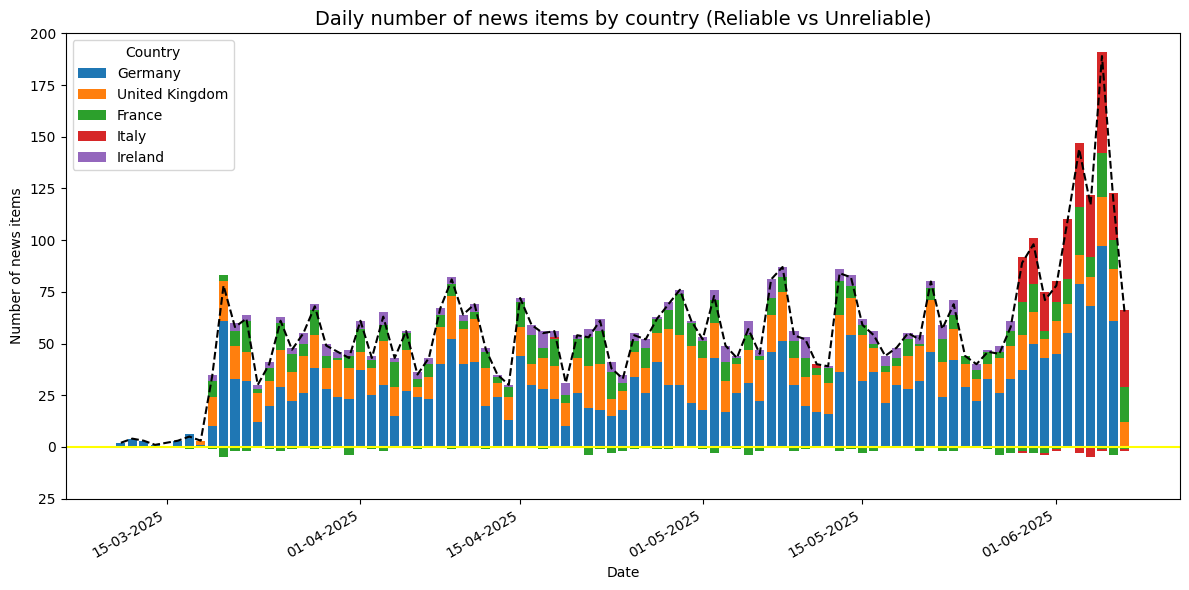

In [ ]:

# %%
# 2️⃣ LOAD the JSON and recreate the diverging bar plot (countries)
TOP_N = 5   # Number of top countries to display
INCLUDE_OTHER = False  # Whether to include an aggregated 'Other' category for remaining countries
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas()
df_loaded_pd.sort_values("date", inplace=True)
# Determine top countries by total reliable+unreliable counts
country_sums_reliable = df_loaded_pd[[c for c in df_loaded_pd.columns if c.endswith("_reliable")]].sum()
country_sums_unreliable = df_loaded_pd[[c for c in df_loaded_pd.columns if c.endswith("_unreliable")]].sum()
country_sums_reliable.index = [idx.replace("_reliable", "") for idx in country_sums_reliable.index]
country_sums_unreliable.index = [idx.replace("_unreliable", "") for idx in country_sums_unreliable.index]
total_extremes = country_sums_reliable.add(country_sums_unreliable, fill_value=0)
if len(total_extremes) > TOP_N:
    top_countries = total_extremes.nlargest(TOP_N).index.tolist()
    other_countries = [country for country in total_extremes.index if country not in top_countries]
else:
    top_countries = total_extremes.index.tolist()
    other_countries = []
df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
for country in top_countries:
    rel_col = f"{country}_reliable"
    unrel_col = f"{country}_unreliable"
    if rel_col not in df_loaded_pd.columns:
        df_loaded_pd[rel_col] = 0
    if unrel_col not in df_loaded_pd.columns:
        df_loaded_pd[unrel_col] = 0
    df_plot[rel_col] = df_loaded_pd[rel_col]
    df_plot[unrel_col] = df_loaded_pd[unrel_col]
if INCLUDE_OTHER and other_countries:
    other_rel_cols = [f"{country}_reliable" for country in other_countries if f"{country}_reliable" in df_loaded_pd.columns]
    other_unrel_cols = [f"{country}_unreliable" for country in other_countries if f"{country}_unreliable" in df_loaded_pd.columns]
    df_plot["Other_reliable"] = df_loaded_pd[other_rel_cols].sum(axis=1) if other_rel_cols else 0
    df_plot["Other_unreliable"] = df_loaded_pd[other_unrel_cols].sum(axis=1) if other_unrel_cols else 0
    categories = top_countries + ["Other"]
else:
    categories = top_countries
fig, ax = plt.subplots(figsize=(12, 6))
color_cycle = plt.rcParams['axes.prop_cycle']()
colors_map = {cat: next(color_cycle)['color'] for cat in categories}
bottom_pos = np.zeros(len(df_plot))
for cat in categories:
    rel_col = f"{cat}_reliable"
    ax.bar(df_plot["date"], df_plot[rel_col], bottom=bottom_pos, color=colors_map[cat], label=cat)
    bottom_pos += df_plot[rel_col].to_numpy()
bottom_neg = np.zeros(len(df_plot))
for cat in categories:
    unrel_col = f"{cat}_unreliable"
    ax.bar(df_plot["date"], -df_plot[unrel_col].to_numpy(), bottom=-bottom_neg, color=colors_map[cat])
    bottom_neg += df_plot[unrel_col].to_numpy()
diff_series = bottom_pos - bottom_neg
ax.plot(df_plot["date"], diff_series, c="k", ls="--")
ax.axhline(0, color="yellow")  # highlight zero baseline
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"), fontsize=14)
_maybe_format_date_axis(ax, df_plot["date"])
ticks = ax.get_yticks()
ax.set_yticks(ticks, [int(abs(t)) for t in ticks])
ax.legend(title="Country")
plt.tight_layout()
plt.show()


In [ ]:

# %%
# ────────────────────────────────────────────────────────────
# TOPIC news counts over time (diverging by reliability)
# ────────────────────────────────────────────────────────────
topic_counts_df = (
    df_window[df_window["reliability_category"] != "mid"]
    .groupby(["date", "topic", "reliability_category"])
    .size()
    .reset_index(name="count")
)
pivot_topic_rel = topic_counts_df[topic_counts_df["reliability_category"] == "reliable"] \
    .pivot(index="date", columns="topic", values="count").fillna(0)
pivot_topic_unrel = topic_counts_df[topic_counts_df["reliability_category"] == "unreliable"] \
    .pivot(index="date", columns="topic", values="count").fillna(0)
pivot_topic_rel.sort_index(inplace=True)
pivot_topic_unrel.sort_index(inplace=True)
pivot_topic_rel = pivot_topic_rel.astype(int)
pivot_topic_unrel = pivot_topic_unrel.astype(int)
pivot_topic_rel_reset = pivot_topic_rel.reset_index()
pivot_topic_unrel_reset = pivot_topic_unrel.reset_index()
if pivot_topic_rel_reset.columns[0] != "date":
    pivot_topic_rel_reset = pivot_topic_rel_reset.rename(columns={"index": "date"})
if pivot_topic_unrel_reset.columns[0] != "date":
    pivot_topic_unrel_reset = pivot_topic_unrel_reset.rename(columns={"index": "date"})
pivot_topic_rel_reset = pivot_topic_rel_reset.rename(columns={col: f"{col}_reliable" for col in pivot_topic_rel_reset.columns if col != "date"})
pivot_topic_unrel_reset = pivot_topic_unrel_reset.rename(columns={col: f"{col}_unreliable" for col in pivot_topic_unrel_reset.columns if col != "date"})
topic_merged = pd.merge(pivot_topic_rel_reset, pivot_topic_unrel_reset, on="date", how="outer").fillna(0)
topic_merged.sort_values("date", inplace=True)
topic_cols = [c for c in topic_merged.columns if c != "date"]
topics = set()
for col in topic_cols:
    if col.endswith("_reliable"):
        topics.add(col.replace("_reliable", ""))
    elif col.endswith("_unreliable"):
        topics.add(col.replace("_unreliable", ""))
num_topics = len(topics)
if num_topics > 10:
    print(f"📊 {num_topics} topics found. All topics included in JSON (visualization will default to top 10 with 'Other'; configurable).")
else:
    print(f"📊 {num_topics} topics found. All topics included in JSON.")



📊 3 topics found. All topics included in JSON.


In [ ]:
plot_path = Path("topic_news_counts_diverging.json")
plot_d = {
    "data"      : pl.from_pandas(topic_merged).to_dict(as_series=False),
    "title"     : "Daily number of news items by topic (Reliable vs Unreliable)",
    "xlabel"    : "Date",
    "ylabel"    : "Number of news items",
    "x_data"    : "date",
    "y_data"    : None,
    "chart_type": "bar",
    "platform"  : "News",
}
save_dict(plot_d, plot_path)
print(f"💾 JSON saved → {plot_path.resolve()}")


💾 JSON saved → /home/kadkhoda/topic_news_counts_diverging.json


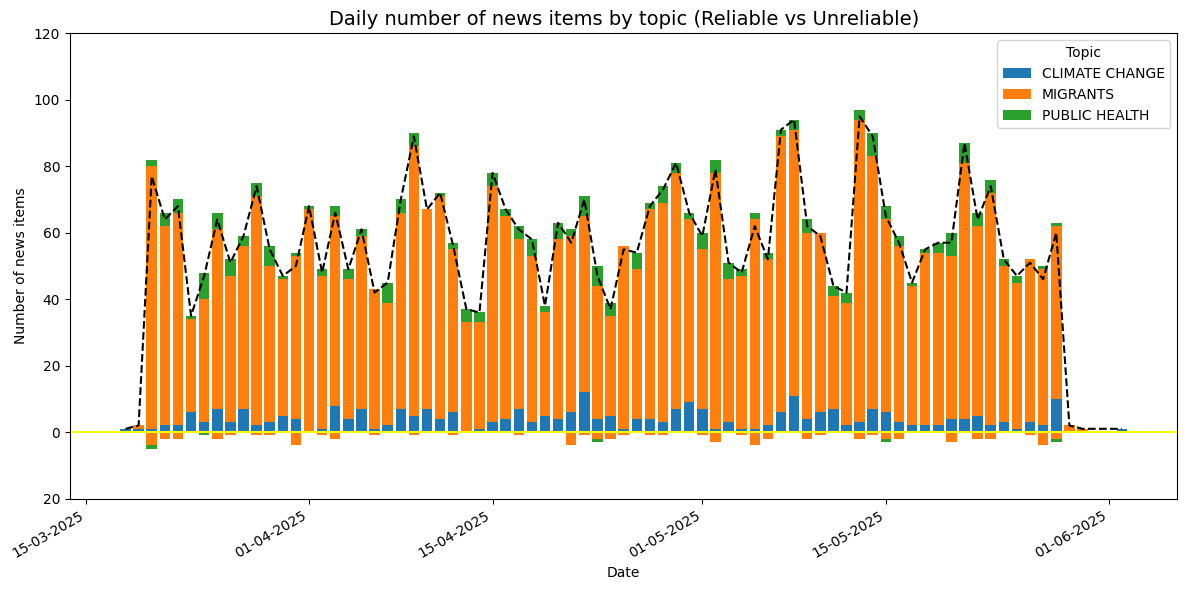

In [ ]:

# %%
# 2️⃣ LOAD the JSON and recreate the diverging bar plot (topics)
TOP_N = 10  # Number of top topics to display
INCLUDE_OTHER = True  # Whether to include an aggregated 'Other' category for remaining topics
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas()
df_loaded_pd.sort_values("date", inplace=True)
topic_sums_reliable = df_loaded_pd[[c for c in df_loaded_pd.columns if c.endswith("_reliable")]].sum()
topic_sums_unreliable = df_loaded_pd[[c for c in df_loaded_pd.columns if c.endswith("_unreliable")]].sum()
topic_sums_reliable.index = [idx.replace("_reliable", "") for idx in topic_sums_reliable.index]
topic_sums_unreliable.index = [idx.replace("_unreliable", "") for idx in topic_sums_unreliable.index]
total_extremes = topic_sums_reliable.add(topic_sums_unreliable, fill_value=0)
if len(total_extremes) > TOP_N:
    top_topics = total_extremes.nlargest(TOP_N).index.tolist()
    other_topics = [topic for topic in total_extremes.index if topic not in top_topics]
else:
    top_topics = total_extremes.index.tolist()
    other_topics = []
df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
for topic in top_topics:
    rel_col = f"{topic}_reliable"
    unrel_col = f"{topic}_unreliable"
    if rel_col not in df_loaded_pd.columns:
        df_loaded_pd[rel_col] = 0
    if unrel_col not in df_loaded_pd.columns:
        df_loaded_pd[unrel_col] = 0
    df_plot[rel_col] = df_loaded_pd[rel_col]
    df_plot[unrel_col] = df_loaded_pd[unrel_col]
if INCLUDE_OTHER and other_topics:
    other_rel_cols = [f"{topic}_reliable" for topic in other_topics if f"{topic}_reliable" in df_loaded_pd.columns]
    other_unrel_cols = [f"{topic}_unreliable" for topic in other_topics if f"{topic}_unreliable" in df_loaded_pd.columns]
    df_plot["Other_reliable"] = df_loaded_pd[other_rel_cols].sum(axis=1) if other_rel_cols else 0
    df_plot["Other_unreliable"] = df_loaded_pd[other_unrel_cols].sum(axis=1) if other_unrel_cols else 0
    categories = top_topics + ["Other"]
else:
    categories = top_topics
fig, ax = plt.subplots(figsize=(12, 6))
color_cycle = plt.rcParams['axes.prop_cycle']()
colors_map = {cat: next(color_cycle)['color'] for cat in categories}
bottom_pos = np.zeros(len(df_plot))
for cat in categories:
    rel_col = f"{cat}_reliable"
    ax.bar(df_plot["date"], df_plot[rel_col], bottom=bottom_pos, color=colors_map[cat], label=cat)
    bottom_pos += df_plot[rel_col].to_numpy()
bottom_neg = np.zeros(len(df_plot))
for cat in categories:
    unrel_col = f"{cat}_unreliable"
    ax.bar(df_plot["date"], -df_plot[unrel_col].to_numpy(), bottom=-bottom_neg, color=colors_map[cat])
    bottom_neg += df_plot[unrel_col].to_numpy()
diff_series = bottom_pos - bottom_neg
ax.plot(df_plot["date"], diff_series, c="k", ls="--")
ax.axhline(0, color="yellow")  # highlight zero baseline
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"), fontsize=14)
_maybe_format_date_axis(ax, df_plot["date"])
ticks = ax.get_yticks()
ax.set_yticks(ticks, [int(abs(t)) for t in ticks])
ax.legend(title="Topic")
plt.tight_layout()
plt.show()
